In [1]:
cd ..

/Users/deepakduggirala/Documents/autonomous-robotics/bev-generation


In [2]:
import json
from pathlib import Path
import zlib

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import lmdb

from utils import bytes_to_array
import utils
import nusc_utils

In [3]:
dataroot = Path('/Users/deepakduggirala/Documents/autonomous-robotics/v1.0-mini/').resolve()
gt_db_path = dataroot / Path('lmdb/samples/GT_BEV_CAM_FRONT')
raw_db_path = dataroot / Path('lmdb/samples/SPARSE_RAW_BEV_CAM_FRONT')

In [4]:
gt_db = lmdb.open(path=str(gt_db_path), readonly=True)
raw_db = lmdb.open(path=str(raw_db_path), readonly=True)

In [6]:
with open('data/v1.0-mini-CAM_FRONT_token.json', 'r') as f:
    tokens=json.load(f)

In [7]:
def db_value_to_array(value):
    value_unzipped = zlib.decompress(value)
    return bytes_to_array(value_unzipped)

In [38]:
token = tokens[3]
cam_token_bytes = str.encode(token, 'utf-8')
cam_token_bytes

b'74e7a9260c5d45b78b831528b62daf41'

In [39]:
with gt_db.begin() as txn:
    value = txn.get(cam_token_bytes)
    bev_gt = db_value_to_array(value)
bev_gt.shape

(15, 196, 200)

In [40]:
# labels = utils.transform_label(bev_gt)
# labels.shape

In [41]:
with raw_db.begin() as txn:
    value = txn.get(cam_token_bytes)
    bev_raw = db_value_to_array(value)
bev_raw.shape

(14, 200, 200)

In [42]:
# pred = utils.transform_pred(bev_raw)
# pred.shape

### Visualizing GT and RAW BEVs

In [43]:
nusc_idx_to_color = {
    0: (0, 207, 191),
    1: (175, 0, 75),
    2: (75, 0, 75),
    3: (112, 180, 60),
    4: (255, 158, 0),
    5: (255, 99, 71),
    6: (255, 69, 0),
    7: (255, 140, 0),
    8: (233, 150, 70),
    9: (138, 43, 226),
    10: (255, 61, 99),
    11: (220, 20, 60),
    12: (47, 79, 79),
    13: (112, 128, 144)
}
color_map_gt = {i + 1: c for i, c in nusc_idx_to_color.items()}
color_map_gt[0] = [255, 255, 255]  # color areas without any class as white
color_map_gt[2] = color_map_gt[1]  # color ped_crossing with same color as drivable_area
color_map_gt[4] = [255, 255, 255]  # do not color "carpark_area" - will be white
# color_map[15] = [255, 255, 255]  # do not color "lidar mask"

color_map_raw = {i + 1: c for i, c in nusc_idx_to_color.items()}
color_map_raw[0] = [255, 255, 255]
color_map_raw[2] = [255, 255, 255]  # do not color "other_flat" - will be white
color_map_raw[4] = [255, 255, 255]  # do not color "terrain" - will be white

In [44]:
bev_gt_map_cmp = utils.make_composite(bev_gt[:-1,:,:]) # do not apply visible (lidar + fov) mask
bev_seg_map_cmp = utils.make_composite(bev_raw)


bev_gt_map_cmp_color = utils.color_components(bev_gt_map_cmp, color_map=color_map_gt)
bev_seg_map_cmp_color = utils.color_components(bev_seg_map_cmp, color_map=color_map_raw)

(-0.5, 199.5, 199.5, -0.5)

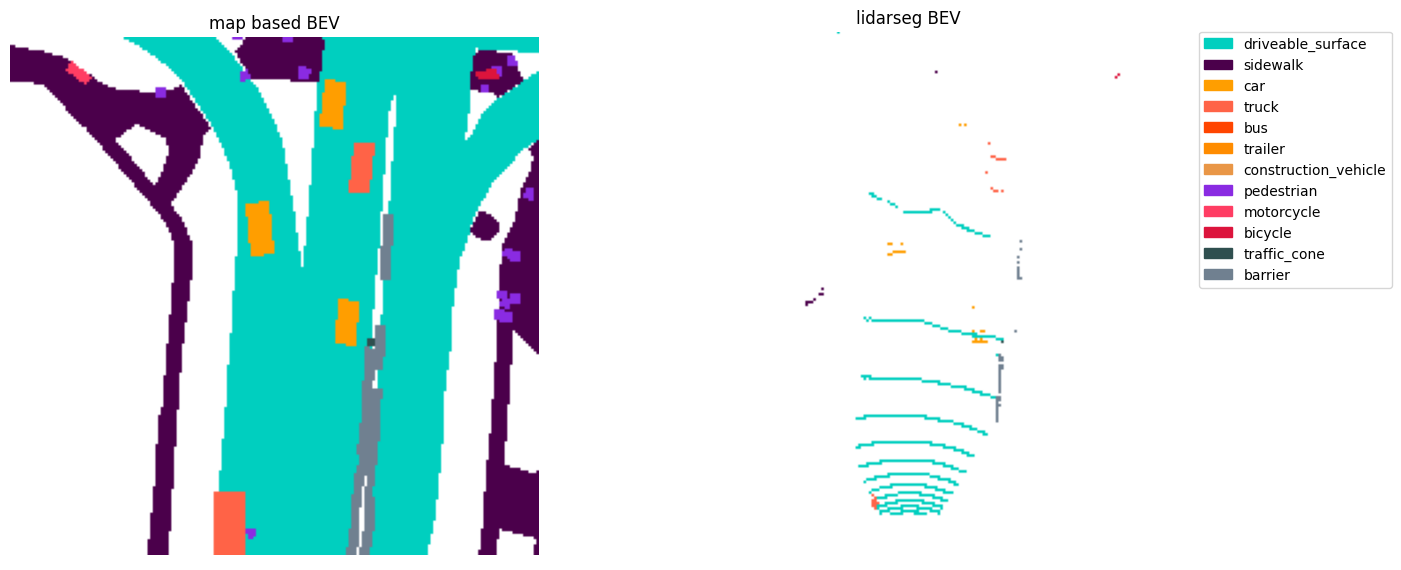

In [45]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))
ax = axs[0]
ax.imshow(np.flip(bev_gt_map_cmp_color, 0))
ax.set_title('map based BEV')
ax.axis('off')

ax = axs[1]
ax.imshow(bev_seg_map_cmp_color)
ax.set_title('lidarseg BEV')

legend_colors = [np.append(np.array(nusc_idx_to_color[idx]) / 255, 1) for idx in range(len(nusc_idx_to_color))]
patches = [mpatches.Patch(color=legend_colors[i], label=label)
           for i, label in enumerate(nusc_utils.NUSC_LIDAR_CLASS_NAMES) if i not in [1, 3]]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('off')